In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random

In [4]:
names = open('names.txt').read().split('\n')
chars = {'.':0,}
set_chars = set()
for i in names:
    for j in str(i):
        set_chars.add(j)
for i, letter in enumerate(sorted(list(set_chars))):
    chars[letter] = i + 1
keys_chars = list(chars.keys())

In [5]:
#  ... e
#  ..e m
#  .em m
#  emm a
#  mma .
X, Y = [], []
prev_lett = 3

for name in names:
    list_to_loop_of_names = ['.'] + list(name) + ['.']
    for letter in range(len(list_to_loop_of_names)-1):
        X_here, k = [], 0
        while prev_lett-letter-k > 0:
            X_here.append(0)
            k += 1
        while len(X_here) < prev_lett:
            # print(letter, len(X_here))
            X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
        X.append(X_here)
        Y.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
def make_dataset(names):
    Xs, Ys = [], []
    for name in names:
        list_to_loop_of_names = ['.'] + list(name) + ['.']
        for letter in range(len(list_to_loop_of_names)-1):
            X_here, k = [], 0
            while prev_lett-letter-k > 0:
                X_here.append(0)
                k += 1
            while len(X_here) < prev_lett:
                X_here.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
            Xs.append(X_here)
            Ys.append(chars[list_to_loop_of_names[letter+len(X_here)-prev_lett+1]])
    return torch.tensor(Xs), torch.tensor(Ys)
random.shuffle(names)
n1, n2 = int(0.8 * len(names)), int(0.9 * len(names))
Xtrain, Ytrain = make_dataset(names[:n1])
Xval, Yval = make_dataset(names[n1:n2])
Xtest, Ytest = make_dataset(names[n2:])

In [7]:
# CONSTS 
num_dim = 30
num_input = prev_lett*num_dim
num_W1 = 100
num_W2 = 27
batch_size = 32

In [61]:
g = torch.Generator()
g.manual_seed(2147483647)

C = torch.randn(27, num_dim)
W1 = torch.randn(num_input, num_W1) * 0.3
b1 = torch.randn(num_W1) * 0
W2 = torch.randn(num_W1, num_W2) * 0.1
b2 = torch.randn(num_W2) * 0

bn_bias = torch.zeros((1, num_W1))
bn_mult = torch.ones((1, num_W1))

bn_mean_mean = torch.zeros((1, num_W1))
bn_std_mean = torch.ones((1, num_W1))

P = [C, W1, b1, W2, b2, bn_bias, bn_mult]
for p in P:
    p.requires_grad = True

In [72]:
epochs = 70000
steps, losses = [], []
for epoch in range(epochs):
    samples_on_this_epoch = torch.randint(0, len(Xtrain), (batch_size,))
    X_on_this_epoch = C[Xtrain[samples_on_this_epoch]].view(-1, prev_lett*num_dim)
    Y_on_this_epoch = Ytrain[samples_on_this_epoch]
    # first_stage = C[X] 
    h1 = X_on_this_epoch @ W1 + b1
    h1_mean_this_stage = h1.mean(0, keepdims=True)
    h1_std_this_stage = h1.std(0, keepdims=True)
    h1 = bn_mult * (h1 - h1_mean_this_stage)/(h1_std_this_stage+ 0.0001) + bn_bias
    h1 = torch.tanh(h1)
    output = h1 @ W2 + b2

    with torch.no_grad():
        bn_mean_mean = 0.999 * bn_mean_mean + 0.001 * h1_mean_this_stage
        bn_std_mean = 0.999 * bn_std_mean + 0.001 * h1_std_this_stage

    loss = F.cross_entropy(output, Y_on_this_epoch)
    for p in P:
        p.grad = None
    loss.backward()
    lr = 0.1 if epoch/epochs < 0.3 else 0.01

    for p in P:
        p.data += -lr * p.grad
    # W1.data += -lr * W1.grad
    # W2.data += -lr * W2.grad
    # b1.data += -lr * b1.grad
    # b2.data += -lr * b2.grad

    steps.append(epoch)
    losses.append(loss.item())


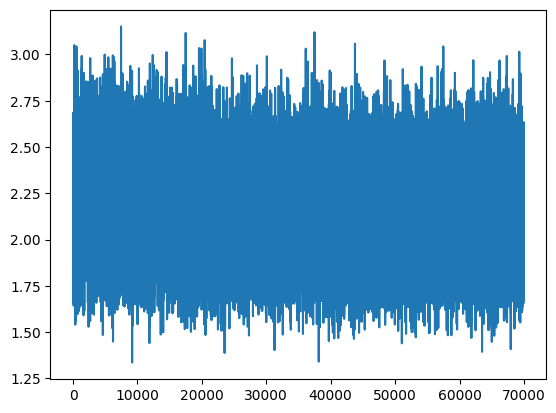

In [73]:
plt.plot(steps, losses);

In [74]:
def check_loss(dataX, dataY):
    losses_checker = []
    for i in range(100):
        samples_on_this_epoch = torch.randint(0, len(dataX), (batch_size,))
        X_on_this_epoch = C[dataX[samples_on_this_epoch]].view(-1, prev_lett*num_dim)
        Y_on_this_epoch = dataY[samples_on_this_epoch]
        # first_stage = C[X] 
        h1 = X_on_this_epoch @ W1 + b1
        h1 = bn_mult * (h1 - bn_mean_mean)/(bn_std_mean+ 0.0001) + bn_bias
        h1 = torch.tanh(h1)
        output = h1 @ W2 + b2
    
        loss = F.cross_entropy(output, Y_on_this_epoch)
        losses_checker.append(loss.item())
    return torch.tensor(losses_checker).mean().item()

In [75]:
print(check_loss(Xval, Yval))
print(check_loss(Xtest, Ytest))


2.1519057750701904
2.1561074256896973


In [76]:
examples = []
for i in range(15):
    inp_letters = [0, 0, 0]
    example = []
    while True:
        lol = torch.tensor(inp_letters)
        X_on_this_epoch = C[lol].view(-1, prev_lett*num_dim)
        
        h1 = X_on_this_epoch @ W1 + b1
        h1 = bn_mult * (h1 - bn_mean_mean)/(bn_std_mean+ 0.0001) + bn_bias
        h1 = torch.tanh(h1)
        output = h1 @ W2 + b2
        
        probs = output.exp()/torch.sum(output.exp(), dim=1, keepdim=True)
        letter = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        inp_letters.append(letter)
        inp_letters.pop(0)
        example.append(keys_chars[letter])
        letter = keys_chars[letter]
        if letter == '.':
            break
    examples.append(''.join(example))
print(examples)

['carrena.', 'din.', 'jamii.', 'maynin.', 'anaasna.', 'josesporehadios.', 'matta.', 'kazir.', 'paul.', 'tyde.', 'jayreli.', 'isa.', 'dymi.', 'mjenuj.', 'mahvin.']


In [77]:
for i in examples:
    print(f'- {i}')
    # print('\n')
    

- carrena.
- din.
- jamii.
- maynin.
- anaasna.
- josesporehadios.
- matta.
- kazir.
- paul.
- tyde.
- jayreli.
- isa.
- dymi.
- mjenuj.
- mahvin.
